# To do
1. Zoom into taxi maps
2. Analyze Near North in the same way as the Loop
3. Use Taxi ID to see travel patterns for single taxis on a given day, e.g. distribution of number of pickup/dropoff at busy areas in a day.

# Motivation
As in many other major cities, traffic in Chicago can be treacherous at peak times. Bad traffic is an example of a tragedy of the commons problem. Individuals take advantage of a shared resource (roads), which is provided at very low cost, in a way that they each perceive to be best for their own self-interest. The result is an overuse of the resource, leading to reduced utility for everyone.

There are many ways to tackle such a problem, but one solution for bad traffic that is popular among urban economists is road pricing. The basic idea of road pricing is to impose a fee on the use of the streets when itt results in lost time for others; in econ-lingo, this tries to price in the externalities of using the roads at peak times. Many of the cars in the problematic downtown areas are taxis and, increasingly, ride-hailing services like Uber and Lyft. The pref is to nudge people into using public transport rather than getting on cars individually, so that they can travel more efficiently in terms of occupied road space.

The goal of the following analysis is to determine which areas at what times may benefit the most from such an intervention, and to explore what kinds of pricing scheme would be most effective.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## When and where is traffic bad?
First, I will look at which areas in Chicago have the worst traffic problems. Past congestion data, from bus tracking, is at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/emtn-qqdi.

Unfortunately, this dataset hasn't been updated since 2015 (there is a live tracking feed for current conditions). Also, there are big glitches where the data from 2015 are all labeled as being from January, and all data from 2013 and 2014 are labeled as being taken at 11pm. I have used the 2015 data, assuming that the entries are essentially correct aside from the month and that the data is still representative of the traffic patterns.

Region ID correspondence is given at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd.

In [2]:
#Look at historical congestion data
df_cong = pd.read_csv('Data/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region.csv')

In [3]:
#Parse TIME
cong_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
df_cong['TIME'] = df_cong['TIME'].apply(cong_parser)

In [4]:
df_cong['year'] = df_cong['TIME'].apply(lambda x: x.year)
df_cong['hour'] = df_cong['TIME'].apply(lambda x: x.hour)
df_cong['weekday'] = df_cong['TIME'].apply(lambda x: x.weekday() < 5) #True if weekday

In [5]:
#Limit myself to 2015
df_cong = df_cong[df_cong.year == 2015]

Make plots of average bus speeds by hour, for 4 centrally located areas. Plot overall average, weekday average, then weekends.

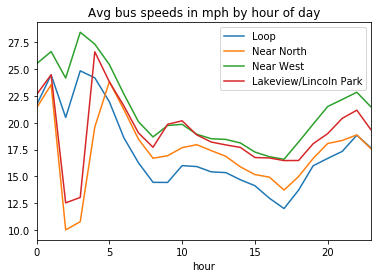

In [6]:
df_cong[(df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day')
plt.legend()
plt.savefig('Figs/bus_speed.png')
plt.show()

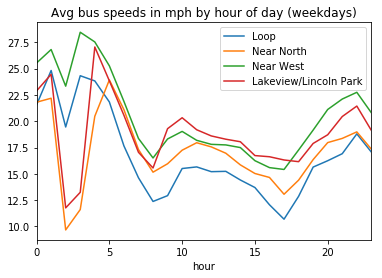

In [7]:
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekday_bus_speed.png')
plt.show()

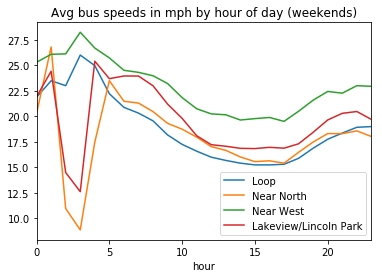

In [8]:
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekends)')
plt.legend()
plt.savefig('Figs/weekend_bus_speed.png')
plt.show()

The dips in early morning appear because very few buses are being tracked; some rows show 0.0 as the average speed. These are artifacts of the data taking process and is not indicative of the traffic condition.

Some features in the weekday plot are obvious if you spend any time in the city:
1. There is a small dip at 8-9am for the morning commute.
2. There is a deeper dip around 5pm.

The Loop is identified as uniquely congested (no surprise), with Near North firmly in second place.

Comparing also with plots for 2 other, less central areas (shown below) shows that Near West and Lakeview/Lincoln Park are not especially congested in relation to them, which is mildly surprising. The notable features for them are the slightly busier afternoon commutes for Near West, and larger nighttime and weekend activities in Lakeview/Lincoln Park.

These are statements about average speeds, and it is an open question whether areas outside the top 2 experience episodic bad traffic that may require a deeper look. Event traffic (e.g. Cubs home games in Lakeview) can be significant for short periods of time.

Nevertheless, the first focus should be the Loop, and late afternoon/early evening around 4-7pm.

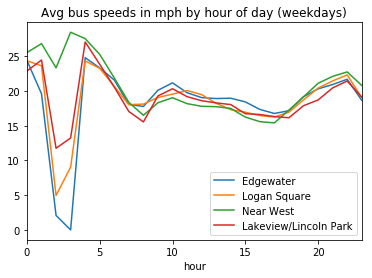

In [9]:
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 4) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Edgewater') #Edgewater
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 7) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Logan Square') #Logan Square
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekday_comparison.png')
plt.show()

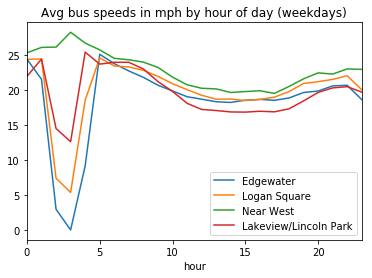

In [10]:
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 4) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Edgewater') #Edgewater
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 7) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Logan Square') #Logan Square
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekend_comparison.png')
plt.show()

## Where do taxis take people from/to the Loop
Now I look at a small piece of the ~40GB database of taxi trips. (There's surely a better way to code this. To be improved later.)

In [11]:
columns = ['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 
           'Pickup Community Area', 'Dropoff Community Area', 'Fare']
for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                           iterator=True, chunksize=1000000):
    df_Loop = chunk[(chunk['Pickup Community Area'] == 32.) | (chunk['Dropoff Community Area'] == 32.)][columns]
    break

In [12]:
#Write another time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

In [13]:
#Add an hour column
df_Loop['hour'] = df_Loop['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour)

In [14]:
#While we're at it, Fare is recorded in strings starting with $.
#Convert them to floats.
df_Loop.Fare = df_Loop.Fare.apply(lambda x: float(x[1:]))

First, try to see if the taxi usage pattern is consistent with the traffic plots above. Plot the number of trips to and from the Loop by hour of day.

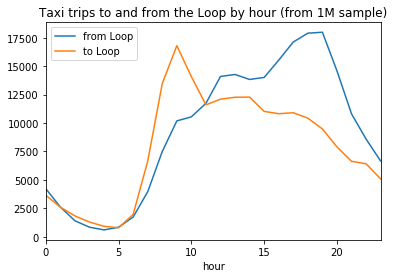

In [15]:
df_Loop[df_Loop['Pickup Community Area'] == 32.].groupby(df_Loop.hour).count()['Trip ID'].plot(label='from Loop')
df_Loop[df_Loop['Dropoff Community Area'] == 32.].groupby(df_Loop.hour).count()['Trip ID'].plot(label='to Loop')
plt.title('Taxi trips to and from the Loop by hour (from 1M sample)')
plt.legend()
plt.savefig('Figs/taxis_by_hour.png')
plt.show()

Again, we see the morning rush (peak at 9) and afternoon/evening rush (broad peak at 16-19). Consistent with common sense, the morning peak is traffic to the Loop, and the afternoon peak is traffic from the Loop.

Next, I'll focus on the evening rush, and look at where the trips are going.

In [16]:
#Keep only hour from 16 to 18 (this goes until 18:59).
df_eve_rush = df_Loop[(df_Loop.hour >= 16) & (df_Loop.hour <= 18)]

In [17]:
#How many are pickups?
print(len(df_eve_rush[df_eve_rush['Pickup Community Area'] == 32]))
#Where do they go?
df_eve_rush[df_eve_rush['Pickup Community Area'] == 32].groupby('Dropoff Community Area').count()['Trip ID']

50541


Dropoff Community Area
1.0        46
2.0        50
3.0       326
4.0       113
5.0       239
6.0      1591
7.0      2178
8.0     18214
9.0         1
10.0       10
11.0        4
12.0        6
13.0       11
14.0       32
15.0       26
16.0       65
17.0        3
18.0        1
19.0        6
20.0        1
21.0       62
22.0      357
23.0       19
24.0     1447
25.0        8
26.0        7
27.0       17
28.0     8726
29.0       37
30.0       14
        ...  
41.0      150
42.0       17
43.0       23
44.0        5
46.0        2
47.0        1
48.0        1
49.0        2
50.0        1
51.0        2
56.0      613
57.0        2
58.0       11
59.0       15
60.0       89
61.0        5
62.0        1
63.0        1
64.0        1
65.0        3
66.0        3
67.0        3
68.0        5
69.0        7
70.0        5
72.0        5
73.0        1
75.0        3
76.0     1839
77.0      209
Name: Trip ID, Length: 70, dtype: int64

In [18]:
#How many are dropoffs?
print(len(df_eve_rush[df_eve_rush['Dropoff Community Area'] == 32]))
#Where do they go?
df_eve_rush[df_eve_rush['Dropoff Community Area'] == 32].groupby('Pickup Community Area').count()['Trip ID']

32142


Pickup Community Area
1.0         9
2.0         8
3.0       101
4.0        18
5.0        32
6.0       516
7.0       584
8.0     11983
10.0        2
11.0        2
13.0        2
14.0        6
15.0        5
16.0        8
20.0        1
21.0       12
22.0       47
23.0        2
24.0      300
27.0        4
28.0     3236
29.0        2
31.0       15
32.0    10866
33.0     1607
34.0       25
35.0       26
36.0        1
38.0        1
39.0       18
40.0        3
41.0      200
42.0        5
43.0        2
44.0        1
56.0      506
59.0        5
60.0        7
61.0        1
62.0        2
65.0        1
69.0        3
70.0        1
76.0     1743
77.0       61
Name: Trip ID, dtype: int64

These would be easier to understand using maps. Use geopandas to draw them.

Boundaries for Community Areas are given at https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6.

In [19]:
import geopandas

In [20]:
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

In [21]:
#Make column for how many trips there are to/from the Loop
df_to_Loop = df_eve_rush[df_eve_rush['Dropoff Community Area'] == 32].groupby('Pickup Community Area').count()['Trip ID']
df_from_Loop = df_eve_rush[df_eve_rush['Pickup Community Area'] == 32].groupby('Dropoff Community Area').count()['Trip ID']


In [22]:
chi_map['To_Loop'] = df_to_Loop
chi_map['From_Loop'] = df_from_Loop

chi_map[['To_Loop', 'From_Loop']] = chi_map[['To_Loop', 'From_Loop']].fillna(0)

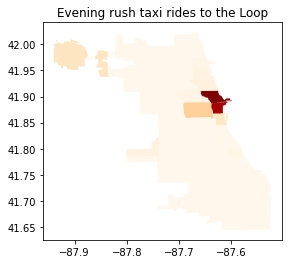

In [23]:
chi_map.plot(column='To_Loop', cmap='OrRd')
plt.title('Evening rush taxi rides to the Loop')
plt.savefig('Figs/evening_taxi_to_Loop.png')
plt.show()

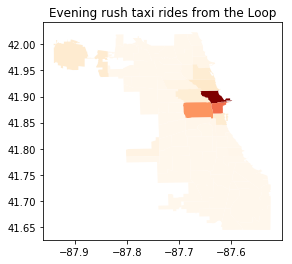

In [24]:
chi_map.plot(column='From_Loop', cmap='OrRd')
plt.title('Evening rush taxi rides from the Loop')
plt.savefig('Figs/evening_taxi_from_Loop.png')
plt.show()

The taxi usage to and from the Loop is heavily concentrated within the Loop and nearby areas, especially Near North and Near West. There is also some cabs to and from O'Hare Airport, which is in the northwest corner.

This is promising for any kind of road pricing scheme, because Near North and Near West are areas that are well-serviced by public transport, with multiple 'L' lines and numerous bus lines. It appears that people are taking taxis for speed and convenience, and not because the destinations are inaccessible by public transport.

## How much are passengers paying for the rides?
From the previous plots, it can be expected that the taxi fares are not very high on average.

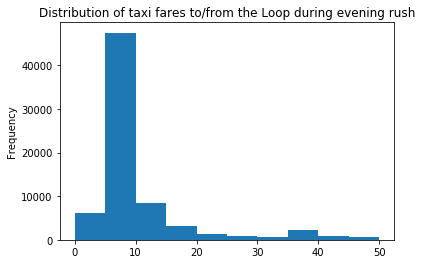

In [25]:
df_eve_rush['Fare'][df_eve_rush.Fare <= 50].plot.hist() #There are some outliers with very high fares
plt.title('Distribution of taxi fares to/from the Loop during evening rush')
plt.savefig('Figs/taxi_fare_hist.png')
plt.show()

There is a huge peak in the range \$5-10, and a full 3/4 of all taxi rides to and from the Loop during the rush have fares less than \$10. This suggests that even a small increase in the cost of using Loop streets at those hours could have a significant impact on the use of taxis (and by proxy, Uber and Lyft).

The small peak between \$35-40 is for O'Hare.